In [1]:
import pandas as pd 
import numpy as np 
import ast 

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.features import GeoJsonTooltip

import geopandas as gpd
from shapely.geometry import Point
import folium
from shapely import wkt 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

### Preparing dataset and merging revelant external attributes to determine livability 

In [2]:
columns = ['suburb', '2021_median_rent', 'population_2021', 'nearest_hospital', 
           'nearest_hospital', 'nearest_train_station', 'distance_to_cbd',
           '2021_unemployment_rate', 'population_density_2021', 
           '2021_annual_income']

combined = pd.read_csv('../data/curated/Final_Merged_Dataset.csv')
combined = combined[columns]

suburbs = combined.groupby('suburb', as_index = False).mean().dropna(how = 'any').reset_index(drop = True)
suburbs = suburbs.reset_index(drop = True).T.drop_duplicates().T

suburbs['2021_annual_income'] = suburbs['2021_annual_income'] / 52

In [3]:
retained_cols = ['SCHOOL_NO', 'Postal_Postcode', 'Address_Town']
vic_schools = pd.read_csv('../data/raw/dv309_schoollocations2021.csv', encoding='cp1252',
                         usecols = retained_cols)

vic_schools['Address_Town'] = vic_schools['Address_Town'].str.lower()

vic_schools = vic_schools.groupby('Address_Town', as_index = False).count()[['Address_Town' , 'SCHOOL_NO']]

In [4]:
suburbs = suburbs.merge(vic_schools, left_on = 'suburb', right_on = 'Address_Town', how = 'left')
suburbs = suburbs.drop('Address_Town', axis = 1)
suburbs['SCHOOL_NO'] = suburbs['SCHOOL_NO'].replace(np.nan, 0)

In [5]:
suburbs['affordability'] =  suburbs['2021_median_rent'] / suburbs['2021_annual_income']
suburbs['school_pop_ratio'] = suburbs['SCHOOL_NO'] / suburbs['population_2021']

rents_2021 = suburbs[['suburb', '2021_median_rent']]

suburbs = suburbs.drop(['2021_annual_income', 'population_2021', '2021_median_rent', 'SCHOOL_NO'], axis = 1)

## K-Means

### Transforming Clustering Data

In [6]:
clustering_df = suburbs[['nearest_hospital', 'nearest_train_station',
       'distance_to_cbd', '2021_unemployment_rate', 'population_density_2021',
       'affordability', 'school_pop_ratio']]

clustering_df = StandardScaler().fit_transform(clustering_df)

### Elbow Method to Determine Ideal Number of Clusters 

In [7]:
distortions = []

for k in range(1,11):
    
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clustering_df)

    distortions.append(kmeanModel.inertia_)

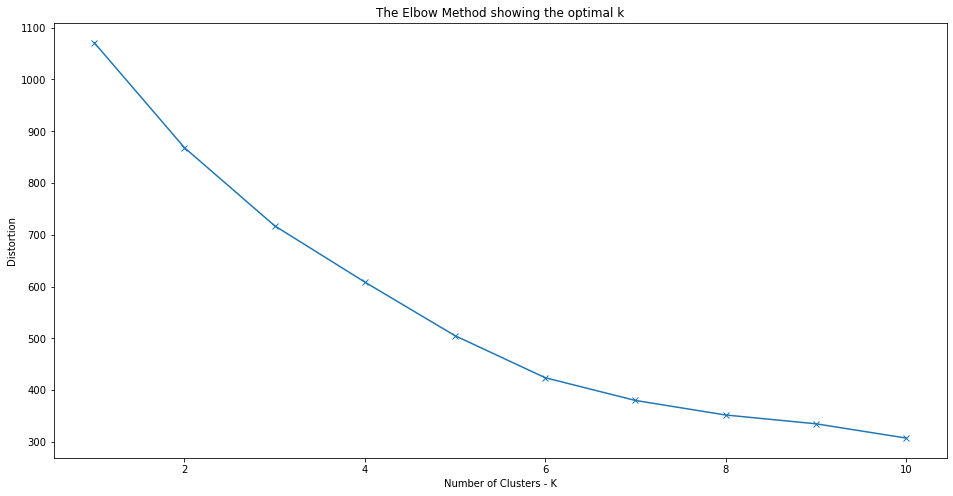

In [8]:
# Only for visual inspection not report

plt.figure(figsize=(16,8))
plt.plot(range(1,11), distortions, 'x-')
plt.xlabel('Number of Clusters - K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=5, random_state = 1234)
kmeans.fit(clustering_df)
suburbs['cluster_number'] = kmeans.predict(clustering_df) + 1

#### Only for visual inspection not report

<Figure size 2160x2160 with 0 Axes>

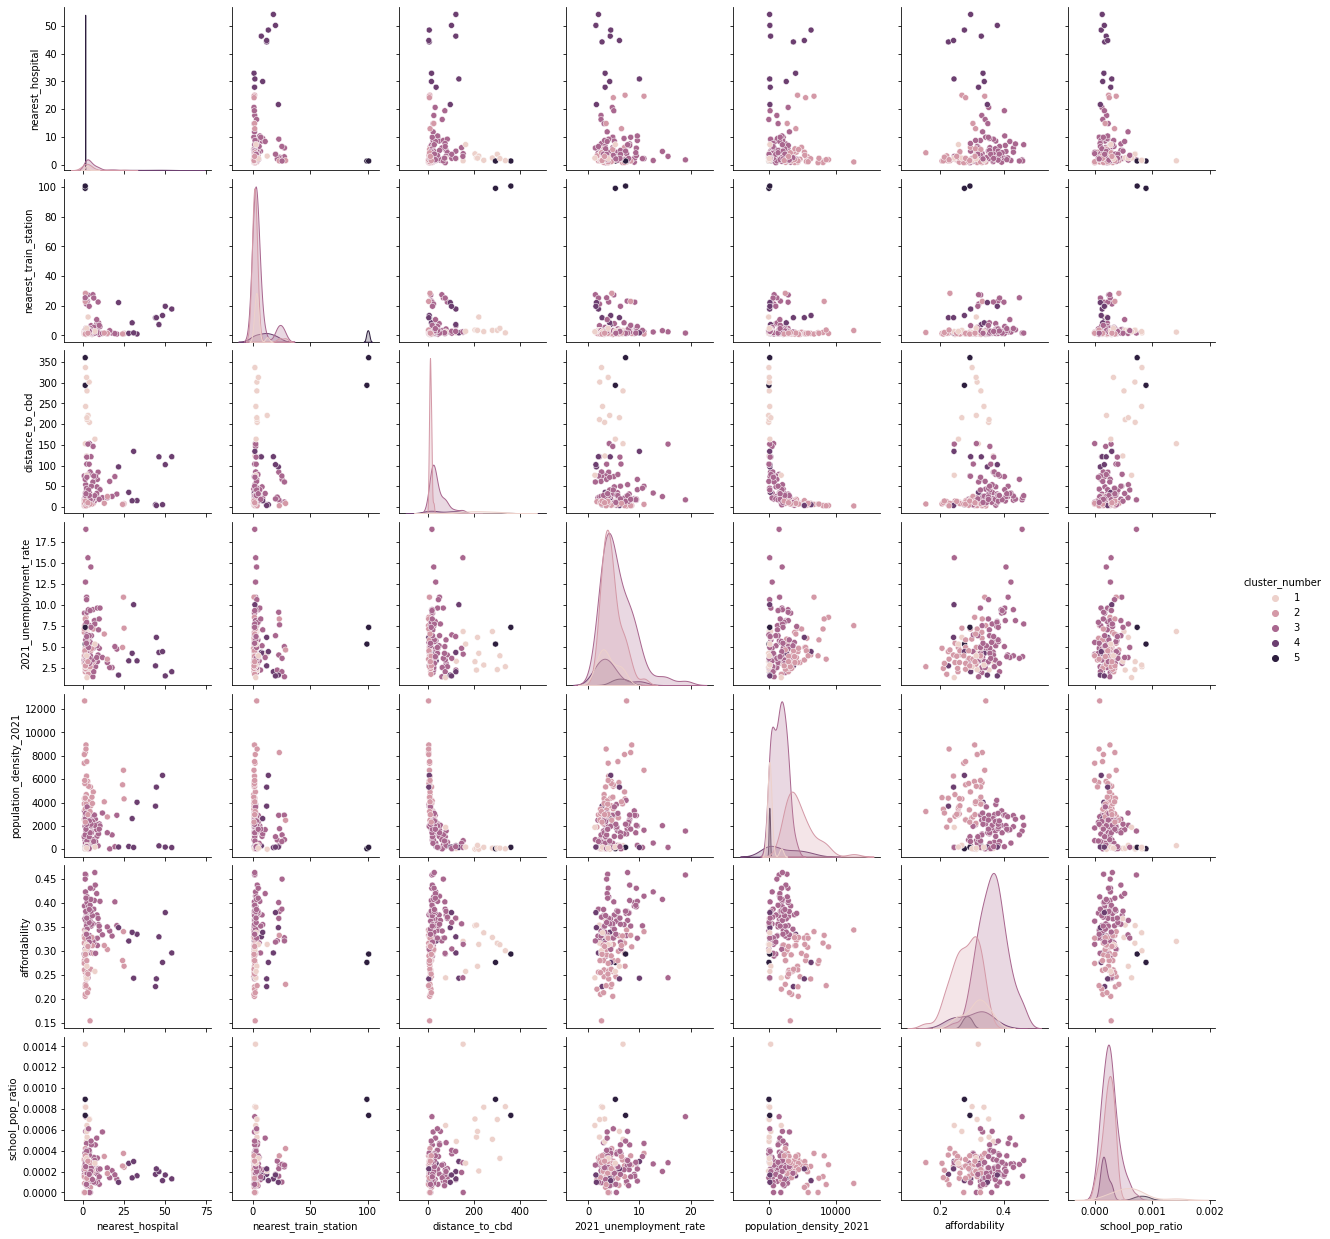

In [10]:
plt.figure(figsize=(30,30))
sns.pairplot(suburbs , hue = 'cluster_number')

In [11]:
suburbs = suburbs.merge(rents_2021, on = 'suburb')

## Clearly cluster 1 has the best mix of all suburbs 

Cluster 1 Properties 

* Most suburbs in cluster 1 are close to CBD
* Closer to train stations
* Pop density - Not too high or too low (Both extremes are bad for liveability) 
* Low unemployment rate - Usually tied to low crime 
* Closest to hospitals

In [12]:
subset_suburbs = suburbs[suburbs['cluster_number'] == 2].reset_index(drop = True) 

numeric_columns = ['nearest_hospital', 'nearest_train_station',
       'distance_to_cbd', '2021_unemployment_rate', 'population_density_2021',
       'affordability', 'school_pop_ratio']

for i in numeric_columns:
    subset_suburbs[i] = subset_suburbs[i].astype(float)
    
subset_suburbs

,suburb,nearest_hospital,nearest_train_station,distance_to_cbd,2021_unemployment_rate,population_density_2021,affordability,school_pop_ratio,cluster_number,2021_median_rent
0,abbotsford,2.934439,1.489185,4.443090,4.50,5804.653835,0.307475,0.000198,2,450.605467
1,alphington,3.177273,1.260436,9.481345,4.90,3463.071431,0.256775,0.000300,2,407.345388
2,armadale,2.048613,0.681178,8.733257,3.10,4677.352874,0.246201,0.000294,2,496.279866
3,ascot vale,25.070790,1.393727,7.824663,7.20,4309.063893,0.268176,0.000242,2,411.042207
4,ashburton,2.938985,0.881708,14.255700,5.40,2827.328492,0.246479,0.000374,2,442.728424
5,blackburn,2.347219,0.887226,21.762893,5.90,2686.431916,0.299278,0.000216,2,404.816494
6,brighton,1.474604,0.992162,12.000320,2.00,2947.625145,0.255761,0.000331,2,675.864941
7,brunswick,2.068227,0.931108,6.760694,6.00,5704.423918,0.331575,0.000068,2,439.000215
8,brunswick west,6.336143,2.118822,8.767689,7.10,4905.173769,0.294919,0.000256,2,382.939865
9,camberwell,2.074086,1.226632,11.824186,4.00,3025.411758,0.259704,0.000136,2,488.599438


### Perform min max scaling on selected suburbs 

In [13]:
from mlxtend.preprocessing import minmax_scaling

final_ranking_df = minmax_scaling(subset_suburbs[numeric_columns], columns=numeric_columns)
final_ranking_df['suburb'] = subset_suburbs['suburb']

final_ranking_df  = final_ranking_df[['suburb'] + 
                                     [ col for col in final_ranking_df.columns 
                                      if col not in ['suburb']]] 

final_ranking_df.head(10)

,suburb,nearest_hospital,nearest_train_station,distance_to_cbd,2021_unemployment_rate,population_density_2021,affordability,school_pop_ratio
0,abbotsford,0.087672,0.029202,0.092803,0.304348,0.362142,0.809777,0.470751
1,alphington,0.097680,0.020935,0.312562,0.347826,0.145100,0.541332,0.713971
2,armadale,0.051163,0.000000,0.279932,0.152174,0.257652,0.485344,0.698521
3,ascot vale,1.000000,0.025752,0.240301,0.597826,0.223515,0.601698,0.575439
4,ashburton,0.087859,0.007247,0.520810,0.402174,0.086173,0.486819,0.889526
5,blackburn,0.063470,0.007447,0.848258,0.456522,0.073114,0.766380,0.514184
6,brighton,0.027506,0.011239,0.422434,0.032609,0.097324,0.535965,0.787026
7,brunswick,0.051972,0.009033,0.193892,0.467391,0.352851,0.937384,0.162127
8,brunswick west,0.227870,0.051958,0.281433,0.586957,0.278769,0.743299,0.609900
9,camberwell,0.052213,0.019713,0.414752,0.250000,0.104534,0.556841,0.323376


### Weighing each metrics the same 

In [14]:
def score_suburb_equal(suburb):
    score = ((suburb['affordability']*-1) +
             (suburb['distance_to_cbd']*-1) + 
             (suburb['nearest_train_station']*-1) + 
             (suburb['school_pop_ratio']*1) +
             (suburb['2021_unemployment_rate']*-1) + 
             (suburb['nearest_hospital']*-1) +
             (suburb['population_density_2021']*1)
            )
    return score

<AxesSubplot:>

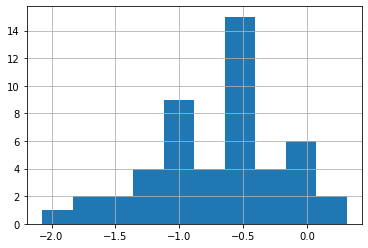

In [15]:
scores = []

numeric_columns = ['nearest_hospital', 'nearest_train_station',
       'distance_to_cbd', '2021_unemployment_rate', 'population_density_2021',
       'affordability', 'school_pop_ratio']

for i in numeric_columns:
    subset_suburbs[i] = subset_suburbs[i].astype(float)
    
subset_suburbs

for suburb in range(len(final_ranking_df)):
    
    curr_suburb = final_ranking_df.iloc[suburb]
    scores.append(score_suburb_equal(curr_suburb))
    
final_ranking_df['score'] = scores
final_ranking_df['score'].hist()

In [16]:
top_10_suburbs = final_ranking_df.sort_values(by='score', ascending=False).reset_index(drop = True).head(10)[['suburb']]
top_10_suburbs['geo_spatial_filler'] = 1

top_10_suburbs

,suburb,geo_spatial_filler
0,toorak,1
1,hawthorn east,1
2,southbank,1
3,hawthorn,1
4,armadale,1
5,elwood,1
6,elsternwick,1
7,brighton,1
8,glen iris,1
9,richmond,1


#### When we weight each metric by the same amount, we find without surprise that the most 'liveable' suburbs are the posh Eastern Suburbs such as Toorak and Brighton etc. But obviously this is not a particuarly useful analysis as it is kind of obvious.

### To make better recommendations we will penalise high rents a bit more to promote more affordable suburbs which can be recommended to a bigger sector of the population, particularly the middle class. 

In [17]:
suburbs

,suburb,nearest_hospital,nearest_train_station,distance_to_cbd,2021_unemployment_rate,population_density_2021,affordability,school_pop_ratio,cluster_number,2021_median_rent
0,abbotsford,2.934439,1.489185,4.44309,4.5,5804.653835,0.307475,0.000198,2,450.605467
1,albert park,44.218611,11.892911,5.411578,2.7,3689.006781,0.22574,0.000174,4,523.010173
2,alfredton,4.955048,6.510578,121.32273,2.2,308.530841,0.295648,0.000123,3,357.208581
3,alphington,3.177273,1.260436,9.481345,4.9,3463.071431,0.256775,0.0003,2,407.345388
4,altona,1.313035,0.931396,18.746987,3.5,796.45117,0.289095,0.000284,3,400.665528
...,...,...,...,...,...,...,...,...,...,...
148,wendouree,2.355989,2.664463,120.395226,6.2,225.177363,0.36814,0.000394,3,357.208581
149,west footscray,2.163598,1.444609,10.739275,5.4,2140.2177,0.334617,0.000078,3,387.98326
150,williamstown,1.569507,0.901973,14.134295,2.7,2322.938078,0.292826,0.000352,2,516.017635
151,wodonga,2.278371,4.705043,312.975948,3.9,98.879859,0.312858,0.000326,1,329.083134


In [18]:
numeric_columns = ['nearest_hospital', 'nearest_train_station',
       'distance_to_cbd', '2021_unemployment_rate', 'population_density_2021',
       'affordability', 'school_pop_ratio', '2021_median_rent']

affordable_final_ranking_df = minmax_scaling(suburbs[numeric_columns], columns=numeric_columns)
affordable_final_ranking_df['suburb'] = suburbs['suburb']

affordable_final_ranking_df  = affordable_final_ranking_df[['suburb'] + 
                                     [ col for col in affordable_final_ranking_df.columns 
                                      if col not in ['suburb']]] 

In [19]:
affordable_final_ranking_df.head(10)

,suburb,nearest_hospital,nearest_train_station,distance_to_cbd,2021_unemployment_rate,population_density_2021,affordability,school_pop_ratio,2021_median_rent
0,abbotsford,0.040090,0.008082,0.005938,0.180791,0.457307,0.496126,0.139344,0.447527
1,albert park,0.814461,0.112150,0.008641,0.079096,0.290465,0.230982,0.122452,0.592669
2,alfredton,0.077991,0.058311,0.332124,0.050847,0.023877,0.457759,0.086564,0.260304
3,alphington,0.044645,0.005794,0.019998,0.203390,0.272647,0.331658,0.211338,0.360808
4,altona,0.009678,0.002503,0.045857,0.124294,0.062355,0.436503,0.199900,0.347418
5,armadale,0.023475,0.000000,0.017911,0.101695,0.368407,0.297356,0.206765,0.539086
6,ascot vale,0.455304,0.007128,0.015375,0.333333,0.339363,0.368642,0.170332,0.368219
7,ashburton,0.040176,0.002006,0.033323,0.231638,0.222512,0.298259,0.263303,0.431737
8,bairnsdale,0.031872,0.027037,0.775779,0.310734,0.007536,0.562389,0.358560,0.168875
9,balwyn,0.039962,0.265883,0.026880,0.209040,0.229973,0.560355,0.172534,0.643319


In [20]:
def score_suburb_penalise_high_rents(suburb):
    score = (
             (suburb['distance_to_cbd']*-1) + 
             (suburb['nearest_train_station']*-1) + 
             (suburb['school_pop_ratio']*1) +
             (suburb['2021_unemployment_rate']*-1) + 
             (suburb['nearest_hospital']*-1) +
             (suburb['2021_median_rent']*-1)
            )
    return score

In [21]:
scores = []
for suburb in range(len(suburbs)):
    
    curr_suburb = suburbs.iloc[suburb]
    scores.append(score_suburb_penalise_high_rents(curr_suburb))
    
suburbs['score'] = scores

In [22]:
new_top_10_suburbs =  suburbs.sort_values(by='score', ascending=False).reset_index(drop = True).head(10)[['suburb']]
new_top_10_suburbs['geo_spatial_filler'] = 1

new_top_10_suburbs.head(6)

,suburb,geo_spatial_filler
0,southbank,1
1,footscray,1
2,sunshine,1
3,deer park,1
4,corio,1
5,thomastown,1


### Geospatial plotting for both sets of suburbs 

In [23]:
vic_sf = gpd.read_file('../data/raw/vic_localities.shp')

def preproc_shapefile(vic_shapefile):
    
    #casefold into lower cases 
    vic_shapefile['LOC_NAME'] = vic_shapefile['LOC_NAME'].str.lower()
    
    #fix up some suburb names
    suburbs.loc[suburbs['suburb'] == 'prahran east','suburb'] = 'prahran'
    suburbs.loc[suburbs['suburb'] == 'preston west','suburb'] = 'preston'
    suburbs.loc[suburbs['suburb'] == 'sanctuary lakes','suburb'] = 'point cook'
    
    #remove duplicates
    vic_shapefile_no_duplicates = vic_shapefile.loc[vic_shapefile['LOC_NAME'].drop_duplicates().index,:]
    
    vic_shapefile['centroid'] = vic_shapefile['geometry'].map(
    lambda polygon: 
        wkt.loads( #after finding centroid, need to re-parse this back into a Point object
            wkt.loads(str(polygon)).centroid.wkt #need str object to find centroid
        )
    )
    
    return vic_shapefile

vic_shapefile_no_duplicates = preproc_shapefile(vic_sf)


def geopandas_plotting(rental_df, 
                       sf, 
                       legend_name='Liveable Suburb', 
                       col_to_be_plot='cost_text',
                       save=False,
                       saved_map_name='',
                       map_format='html', fill_color = 'Reds'):
    
    
    tooltip = GeoJsonTooltip(
    fields=["col_to_be_plot"],
    labels=True
    )
    
    """
    Helper function to plot an aggregated metric by suburb
    (e.g. taking the mean of rental prices per suburb)
    
    Arguments:
    1. rental_df: df containing suburb columns and an aggregated
    metric corresponding to each suburb 
    
    E.g. columns may look like SUBURB || MEAN OF RENTAL PRICES
    
    2. sf: preprocessed victoria shapefile using the function above
    
    3. legend_name: legend text to appear on bottom right of the folium map
    
    4. col_to_be_plot: which numeric col to be plotted 
    
    
    """
    
    #if not specifying the legend name then the default one 
    #here will be used. 
    if not legend_name:
        legend_name = f'Distribution of {col_to_be_plot} across suburbs'

    #sf: shapefile of all victorian suburbs (vic_shapefile_no_duplicates)

    #need to have shapefile and zone lookups (in this case, suburb) before plotting
    

    # Convert the geometry shaape to to latitude and longitude
    # Please attribute this if you are using it
    sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    #gdf = rental_df merged with sf to obtain the geometry for each subrub
    gdf = rental_df.merge(sf[['LOC_NAME', 'geometry']],
            left_on = 'suburb',
            right_on = 'LOC_NAME',
            how='inner').\
            drop(columns=['LOC_NAME'])

    #convert the merged rental_df to a GeoDataFrame 
    gdf = gpd.GeoDataFrame(gdf)

    # combine geopandas with folium to create visualistion,  
    # but still need geojson and folium map object

    #note: drop duplicates because initiallly there are multiple properties in a suburb
    #but to find the geometry we don't require all duplicates. 
    geoJSON = gdf[['suburb', 'geometry']].drop_duplicates('suburb').to_json()

    m = folium.Map(location=[-37.7829335, 144.9575056])

    # refer to the folium documentations on more information on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=gdf, # data source
        columns=['suburb',col_to_be_plot], # the columns required
        key_on='properties.suburb', # this is from the geoJSON's properties
        nan_fill_color='black',
        fill_color = fill_color,
        legend_name=legend_name,
        zoom = 90000000000000000000,
        tool_tip = tooltip 
    )

    c.add_to(m)
    display(m)
    
    if save == True:
        m.save(f'../plots/{saved_map_name}.{map_format}')

### Intial Results - Not Penalising High Rents 

In [24]:
geopandas_plotting(
     top_10_suburbs, 
     vic_shapefile_no_duplicates, 
     col_to_be_plot='geo_spatial_filler',
     save=True,
     map_format='html',
     saved_map_name= 'most_liveable_suburbs'
 )

### Penalising High Rents

In [25]:
geopandas_plotting(
     new_top_10_suburbs, 
     vic_shapefile_no_duplicates, 
     col_to_be_plot='geo_spatial_filler',
     save=True,
     map_format='html',
     fill_color = 'Greens', 
     saved_map_name='top_10_affordable_new',
     legend_name = 'Liveable Subrubs'
 )